In [73]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [74]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
from pyha import *
from pyha.cores import *
from pyha.cores.util import *
import scipy
from scipy import signal
import warnings
warnings.filterwarnings('ignore') # yolo!
import numpy as np

# GitHub cannot display the Table of Contents!

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Info
Fixes bitreversal, performs fftshift and applies average pooling.

Input is expected to be a 36 bit sfix e.g. after the FFTPower core.
Output is 36 bit sfix.

Average pooling cannot be turned off i.e. setting `avg_freq_axis=1, avg_time_axis=1`. Atleas one of them must be 1, this is limited by the Dual Buffer design. If average pooling is not desired much of the core could be greatly simplified...

Maximum value of the internal accumulator is 1.0, thus oveflow may happen. Unlikely for real-life signals.

`avg_freq_axis` controls the memory usage and decimates the output data rate.

`avg_time_axis` decimates output data rate but has ~no effect on resource usage.

# Examples

## Fix bitreversal and fftshift

INFO:sim:Running "MODEL" simulation...
INFO:sim:Running "PYHA" simulation...
100%|██████████| 139264/139264 [00:06<00:00, 20467.34it/s]
INFO:sim:Flushing the pipeline to collect 69632 valid samples (currently have 69376)
INFO:sim:Hardware delay is 258


<IPython.core.display.Javascript object>


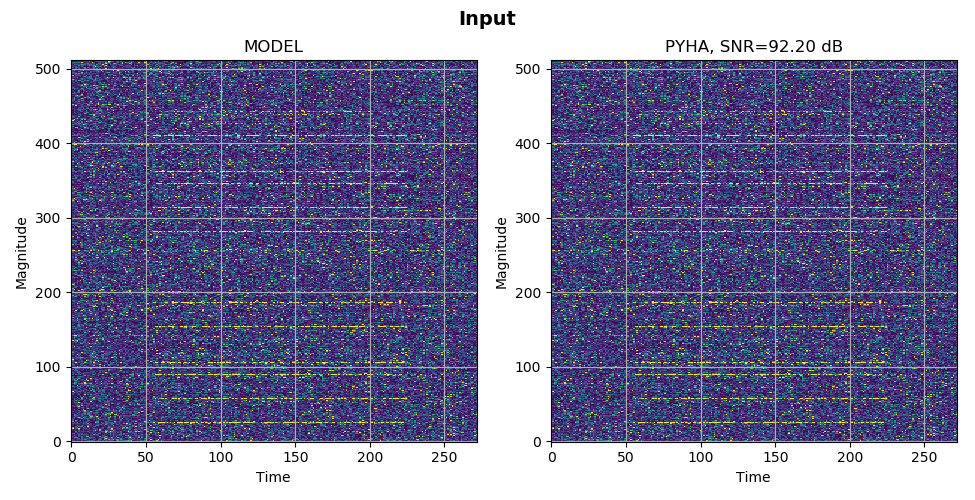

<IPython.core.display.Javascript object>


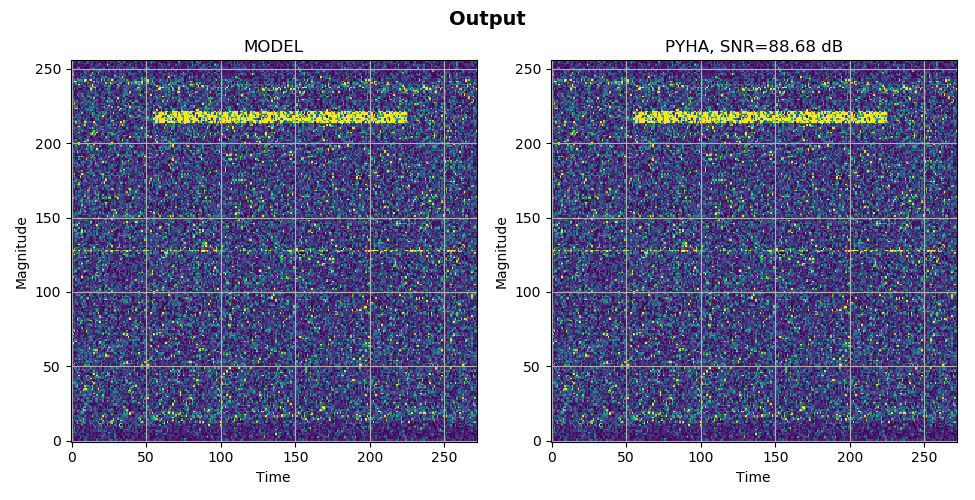

In [69]:
file = get_data_file('phantom3_low_power_bladerf.complex64')
input_signal = load_complex64_file(file)

_, _, spectro_out = signal.spectrogram(input_signal, 1, nperseg=fft_size, return_onesided=False, detrend=False,
                               noverlap=0, window='hann')
spectro_out = toggle_bit_reverse(spectro_out.T) # apply hardware impairments
spectro_out = spectro_out.flatten()

fft_size = 512
dut = BitreversalFFTshiftAVGPool(fft_size, avg_freq_axis=2, avg_time_axis=1)
sims = Simulator(dut, trace=True).run(spectro_out) # run simulations and gather trace
sims.plot_trace(mode={'Input': 'imshow', 'Output': 'imshow'}, rows=len(spectro_out) // fft_size, transpose=True)

## Pool `avg_freq_axis = 8` and `avg_time_axis=16`

INFO:sim:Running "MODEL" simulation...
INFO:sim:Running "PYHA" simulation...
100%|██████████| 139264/139264 [00:06<00:00, 22472.62it/s]
INFO:sim:Flushing the pipeline to collect 1088 valid samples (currently have 1024)
INFO:sim:Hardware delay is 66


<IPython.core.display.Javascript object>


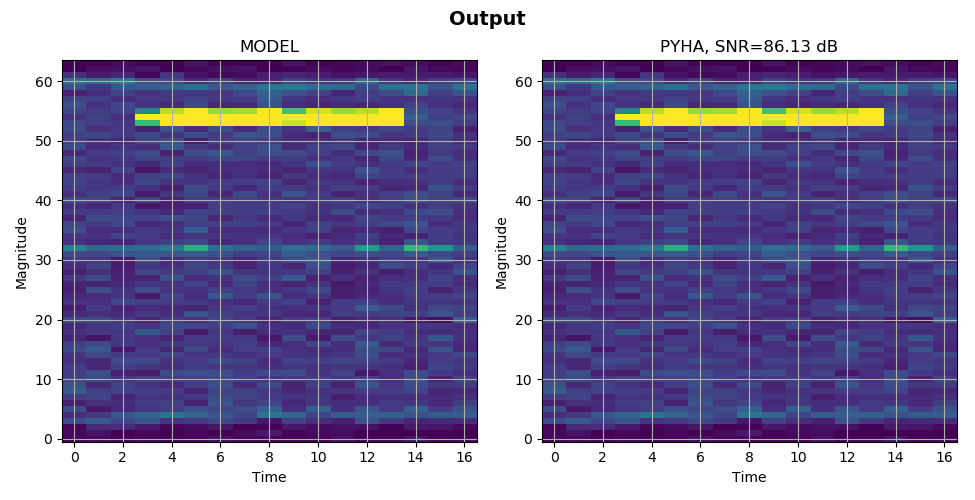

In [72]:
avg_time_axis = 16
dut = BitreversalFFTshiftAVGPool(fft_size, avg_freq_axis=8, avg_time_axis=avg_time_axis)
sims = Simulator(dut, trace=True).run(spectro_out) # run simulations and gather trace
sims.plot_trace(mode={'Input': None, 'Output': 'imshow'}, rows=len(spectro_out) // fft_size // avg_time_axis, transpose=True)

# Conversion to VHDL and RTL/NETLIST simulations

In [76]:
# Pyha design can be converted to VHDL after the PYHA simulation has been ran
# VHDL sources can be used to run the RTL simulation, in addition NETLIST simulation is supported (after Quartus mapper)
# Pyha automatically manages everything needed if you specify the 'RTL', 'NETLIST' flags.
output_dir = '~/Documents/pyha_output'
avg_time_axis = 4
fft_size = 512
input_signal = np.random.normal(size=fft_size * avg_time_axis) * 0.025
dut = BitreversalFFTshiftAVGPool(fft_size=fft_size, avg_freq_axis=8, avg_time_axis=avg_time_axis)
vhdl_sim = Simulator(dut, output_dir=output_dir, extra_simulations=['RTL', 'NETLIST']).run(input_signal)
vhdl_sim.assert_equal(atol=1e-5, rtol=1e-5)

INFO:sim:Simulaton needs to support conversion to VHDL -> major slowdown
INFO:sim:Running "MODEL" simulation...
INFO:sim:Running "PYHA" simulation...
100%|██████████| 2048/2048 [00:00<00:00, 3194.16it/s]
INFO:sim:Flushing the pipeline to collect 64 valid samples (currently have 0)
INFO:sim:Hardware delay is 66
INFO:conversion:Creating top.vhd ...
INFO:conversion:DataValid to VHDL ...
INFO:conversion:RAM to VHDL ...
INFO:conversion:DownCounter to VHDL ...
INFO:conversion:DownCounter to VHDL ...
INFO:conversion:BitreversalFFTshiftAVGPool to VHDL ...
INFO:sim:Running "RTL" simulation...
loading VPI module '/cocotb/build/libs/x86_64/libvpi.so'
VPI module loaded!
100%|##########| 2114/2114 [00:00<00:00, 5961.34it/s]

INFO:sim:Running "NETLIST" simulation...
INFO:synth:Running quartus_map quartus_project...
/quartus/adm/qenv.sh: line 83: warning: setlocale: LC_CTYPE: cannot change locale (en_US.UTF-8): No such file or directory
INFO:synth:Running quartus_eda quartus_project...
/quartus/adm/q

# Synthesis:  resource usage and Fmax

In [77]:
print(vhdl_sim.quartus.get_resource_usage('fit'))
print(vhdl_sim.quartus.get_fmax())

INFO:synth:Running quartus_fit quartus_project...
/quartus/adm/qenv.sh: line 83: warning: setlocale: LC_CTYPE: cannot change locale (en_US.UTF-8): No such file or directory
INFO:synth:Running quartus_sta -t script.tcl...


Family : Cyclone IV E
Device : EP4CE40F23C8
Timing Models : Final
Total logic elements : 317 / 39,600 ( < 1 % )
    Total combinational functions : 308 / 39,600 ( < 1 % )
    Dedicated logic registers : 187 / 39,600 ( < 1 % )
Total registers : 187
Total pins : 76 / 329 ( 23 % )
Total virtual pins : 0
Total memory bits : 4,608 / 1,161,216 ( < 1 % )
Embedded Multiplier 9-bit elements : 0 / 232 ( 0 % )
Total PLLs : 0 / 4 ( 0 % )



/quartus/adm/qenv.sh: line 83: warning: setlocale: LC_CTYPE: cannot change locale (en_US.UTF-8): No such file or directory


+------------------------------------------------+
; Fmax Summary                                   ;
+----------+-----------------+------------+------+
; Fmax     ; Restricted Fmax ; Clock Name ; Note ;
+----------+-----------------+------------+------+
; 99.9 MHz ; 99.9 MHz        ; clk        ;      ;
+----------+-----------------+------------+------+
This panel reports FMAX for every clock in the design, regardless of the user-specified clock periods.  FMAX is only computed for paths where the source and destination registers or ports are driven by the same clock.  Paths of different clocks, including generated clocks, are ignored.  For paths between a clock and its inversion, FMAX is computed as if the rising and falling edges are scaled along with FMAX, such that the duty cycle (in terms of a percentage) is maintained. Altera recommends that you always use clock constraints and other slack reports for sign-off analysis.

